In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import TikTokBot.preprocessing as preproc
import os, glob

In [3]:
raw_data = preproc.load_folders(["./data/tags/hate", "./data/creators/hate"])
data = preproc.prep_vidinfo(raw_data)
print(len(data))

435


/home/jonathan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [6]:
# Loading Max Boeker's data to add to ours
# These were collected around July 2021, likely from a larger range of IPs
# Source: https://github.com/mboeke/TikTok-Personalization-Investigation/blob/7619274d830e76f88a917a5315642df25af96775/utilities/Final%20Test%20Data/training_data_set.csv
mb_data = pd.read_csv("./data/mboeke_data.csv")
mb_data.dropna(inplace=True)
len(mb_data)

33537

In [7]:
# Clean the data and format tags as lists
def format_mb_tags(t):
    t = ['#' + x.lower() for x in t.split()]
    return t
mb_data.loc[:,'tags'] = mb_data.loc[:,'tags'].apply(format_mb_tags)

In [7]:
tags_series = data.tags#pd.concat([data.tags, mb_data.tags], ignore_index=True)
len(tags_series)

435

In [8]:
all_hashtags = list()
all_mentions = list()
for tags in tags_series:
    if len(tags) == 0: continue
    all_hashtags.extend([preproc.remove_emojis(x) for x in tags if x.startswith('#')])
    all_mentions.extend([x for x in tags if x.startswith('@')])

In [9]:
# Filter out the common stuff
common = set()
with open("./generic-tags.txt", 'r') as ifile:
    common = set(ifile.read().split())
all_hashtags = [x for x in all_hashtags if len(x) > 1 and x[1:] not in common]
all_hashtags = list(filter(preproc.common_filter_rules, all_hashtags))

In [10]:
from collections import Counter
c = Counter(all_hashtags)
counts_df = pd.DataFrame.from_dict(c, orient='index').reset_index().rename(columns={'index':'tag', 0:'freq'})
len(counts_df)

1433

In [11]:
counts_df.sort_values('freq', ascending=False)[0:30]

,tag,freq
37,#nationalism,119
8,#based,62
660,#europeforeuropean,56
131,#fascist,53
7,#thirdposition,50
769,#thegreatreset,49
1160,#whiteboysummer,49
102,#traditionalism,40
1284,#czech,40
656,#whitepeoplethings,35


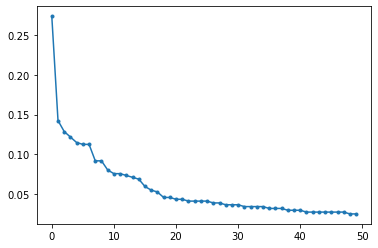

In [12]:
k = 50
freqs = [f / len(tags_series) for f in list(counts_df.freq)]
plt.plot(list(range(k)), sorted(freqs, reverse=True)[:k], marker='.')
plt.show()

In [13]:
# Save all seen IDs to file
data.v_id.to_csv("./to-skip.csv", index=False)

In [15]:
data[data.creator == "miniminuteman"]

,v_id,creator,desc,duration,likes,comments,sound,tags


## Modelling tags

In [27]:
# Format the data for rule mining (v_id is transaction, each tag is an item)
with open("./tag-transactions", "w") as ofile:
    ofile.write("v_id,tag\n")
    for ix, r in data.iterrows():
        for t in r.tags:
            if t[0] == '@': continue # Skip mentions
            clean_t = remove_emojis(t)
            if common_filter_rules(clean_t) and clean_t[1:] not in common and len(clean_t) > 1:
                ofile.write(f"{r.v_id},{t}\n")
    """
    for ix, r in mb_data.iterrows():
        for t in r.tags:
            if t[0] == '@': continue # Skip mentions
            clean_t = remove_emojis(t)
            if common_filter_rules(clean_t) and clean_t[1:] not in common and len(clean_t) > 1:
                ofile.write(f"{r.v_id},{t}\n")
    """

In [28]:
# Format the data for modelling
sentences = list()
with open("./tag-sentences", "w") as ofile:
    for tags in tags_series:
        clean_t = [remove_emojis(t) for t in tags]
        clean_t = sorted(list(filter(lambda t : t[1:] not in common and len(t) > 1, clean_t)))
        clean_t = list(filter(common_filter_rules, clean_t))
        if len(clean_t) > 0:
            sentence = ' '.join(clean_t)
            ofile.write(sentence + '\n')
            sentences.append(sentence)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.4)
X = vectorizer.fit_transform(sentences)

In [30]:
X.shape

(430, 1501)

## Audio extraction

In [50]:
import ffmpeg

In [99]:
vid_url = "https://v16-webapp.tiktok.com/56d17451298e4639dd18a4fc49ebe3f0/623e0e61/video/tos/useast2a/tos-useast2a-ve-0068c001/3fa802bcb9c04747aae8cad0279b2850/?a=1988&br=5390&bt=2695&cd=0%7C0%7C1%7C0&ch=0&cr=0&cs=0&cv=1&dr=0&ds=3&er=&ft=XOQ9-3.Pnz7ThY.2JDXq&l=202203251247540102230201311EBBFAB6&lr=tiktok_m&mime_type=video_mp4&net=0&pl=0&qs=0&rc=M2h3NjU2OGVydTMzaDczM0ApM2VnaTc2aDtkN2Q2NThoaWdtbWZea3IzYzNfLS01MTZzczZjYi02MzAwNDI1NS5fLzM6Yw%3D%3D&vl=&vr="

In [59]:
# Probe the audio streams (use it in case you need information like sample rate):
probe = ffmpeg.probe(vid_url)
probe

'44100'

In [100]:
audio = ffmpeg.input(vid_url).output("pipe:", format="WAV")

In [101]:
a_bytes = audio.run(capture_stdout=True)[0]

In [102]:
with open('audio.wav', 'wb') as f:
    f.write(a_bytes)

In [50]:
import TikTokBot.preprocessing as preproc
df = preproc.prep_vidinfo(pd.read_csv("./data/tags/antivax/nojab.csv"))

In [64]:
isinstance(df["tags"][0], list)

True